In [1]:
%matplotlib inline
from Stupid_digits import *
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from matplotlib import animation
from copy import copy

In [2]:
from PIL import Image

In [3]:
#from brian2 import ms

In [4]:
import torch
torch.manual_seed(2)

In [5]:
descriptor=torch.load('/media/d.nekhaev/cloned/SNN-pytorch/train_X.pth')
y = torch.load('/media/d.nekhaev/cloned/SNN-pytorch/train_y.pth')

descriptor_test=torch.load('/media/d.nekhaev/cloned/SNN-pytorch/test_X.pth')
y_test = torch.load('/media/d.nekhaev/cloned/SNN-pytorch/test_y.pth')

In [6]:
X = descriptor.cpu().numpy()
y = y.cpu().numpy()

In [7]:
X_test = descriptor_test.cpu().numpy()
y_test = y_test.cpu().numpy()

In [8]:
(X[0]**2).sum()

269.33441

In [9]:
from sklearn.manifold import TSNE

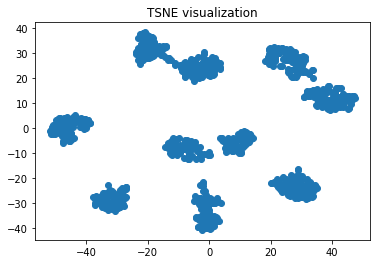

In [10]:
tsne = TSNE()
descriptor2D = tsne.fit_transform(X[:1000])
plt.figure()
plt.title('TSNE visualization')
plt.scatter(descriptor2D[:,0], descriptor2D[:,1])
plt.show()

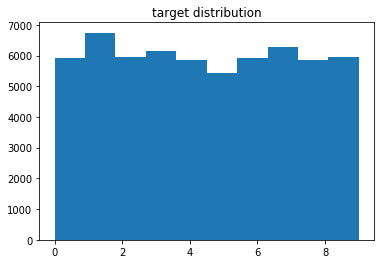

In [11]:
plt.hist(y,bins=len(set(y)))
plt.title('target distribution')
plt.show()

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

In [13]:
KNN = KNeighborsClassifier(n_jobs=10)
KNN.fit(X,y)
preds=KNN.predict(X_test)

In [14]:
accuracy_score(y_test,preds)

0.98580000000000001

In [15]:
LR = LogisticRegression(n_jobs=1)
LR.fit(X,y)
preds=LR.predict(X_test)

In [16]:
accuracy_score(y_test,preds)

0.98740000000000006

In [17]:
X_new = X/5

In [18]:
X = X_new

In [21]:
X[0].sum()

13.77169

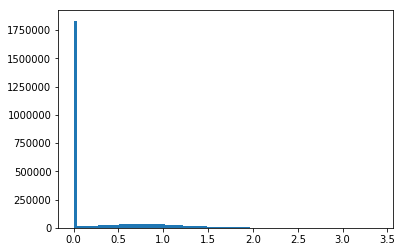

In [22]:
plt.hist(X.reshape(-1),bins=100)
plt.show()

In [23]:
from brian2 import *
import numpy as np
from time import clock

import json
import codecs

def sv_json(obj, path, encoding="cp1251"):
    with codecs.open(path, "w", encoding=encoding) as f:
        json.dump(obj, f, indent=1, ensure_ascii=0)
        
def ld_json(path, encoding="cp1251"):
    with codecs.open(path, "r", encoding=encoding) as f:
        return json.load(f)

start_scope()

time_per_image = 100*ms
time_step = 0.1*ms
tau = 10*ms # tau for neuron's voltage 'v'
tau_I = 15*ms # tau for neuron's current 'I'
tau_h = 50*ms # tau for neuron's treshold

wmax = 1.
decay = 0.001

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
train :1
'''

eqs_output_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_intr/dt = -I_intr/tau_I :1
I_teacher :1
I = I_inp + I_intr + I_teacher : 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_output/dt = -hold_output/tau_h  : 1
fixed_hold_output = clip(hold_output, 1, 5) :1
train :1
'''
#fixed_hold_output = clip(hold_output, 1, 100) :1

eqs_input_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-riented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./classes *1*ms/(alpha)
theta_pre += 1./classes *1*ms/(beta)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
a_post += 1./n_input *1*ms/(alpha)
theta_post += 1./n_input *1*ms/(beta)
w = clip(w + train_post*(-decay + lr*diff_pre), 0, wmax)
'''

eqs_intrinsic_output_syn = '''
w: 1
'''

# equations that describe changes if spike of the intr output synapse occures
eqs_intrinsic_output_pre = '''
I_intr_post += w * c_intr_out
'''

eqs_intrinsic_output_post = '''
w = clip(w + train_pre*(-lr_intr*diff_pre), -wmax, 0)
'''


reset_output = '''
v = 0
hold_output += 0.1*classes
'''

class Perceptron(object):
    def __init__(self, X, y, params_to_optimize, inits = None, monitor = None, cheat = False, mod = True, 
                high_verbosity=True):
        
        '''
        X - np.array with shape (N samples, N features)
        y - np.array with shape (N samples)
        n_hiiden - number of hidden neurons
        inits  - list of 2 lists that contain 'distribution' and 'condition' parameters 
        for input, intrinsic, output and intrinsic_output connections
            Example: inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j']]
        monitor - dictionary with keys 'P', 'G', 'H' or connection names. Each key argument value is dictionary.
        Contains a list of what parameters to record for the object in the key name and dt.
            Example: monitor = {'H':{'variables':[['a','I'],'dt':25*ms, 'record':True]}}
        cheat - True if you wanna use pretrained model with first layer initialized from some objects of training data
        '''
        
        self.high_verbosity = high_verbosity
        global alpha, beta, lr, lr_intr, c_inp, c_intr_out, c_diff, Teacher_amplitude

        alpha = params_to_optimize['alpha']
        beta = params_to_optimize['beta']
        lr = params_to_optimize['lr']
        lr_intr = params_to_optimize['lr_intr']
        c_inp = params_to_optimize['c_inp']
        c_intr_out = params_to_optimize['c_intr_out']
        c_diff = params_to_optimize['c_diff']
        Teacher_amplitude = params_to_optimize['Teacher_amplitude']
        
        self.X = X
        if self.X is not None:
            n_input = int(X.shape[1])
        else:
            raise ValueError('No data provided to the simulation')
        
        self.y = y
        classes = int(len(set(y)))
        
        # list to store initial values for synapses in order [input, intrinsic, output, intrinsic_output]
        if inits:
            pass
        else:
            inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j']]
         
        #creatitng the network: groups and synapses
        
        self.P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', 
                             refractory=2*ms, dt = time_step, name='P')
        #experiment
        self.M = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear',
                             refractory=2*ms, dt = time_step, name='M')
        self.H = NeuronGroup(classes, eqs_output_neuron, method=linear, threshold='v > fixed_hold_output', 
                             reset=reset_output, refractory=2*ms, dt=time_step, name = 'H')
        self.create_synapse('input_syn', self.P, self.H, eqs_input_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        self.create_synapse('input_inverse_syn', self.M, self.H, eqs_input_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        self.create_synapse('intrinsic_output_syn', self.H, self.H, eqs_intrinsic_output_syn, 
                            eqs_intrinsic_output_pre, eqs_intrinsic_output_post, 
                            distribution=inits[1][0], condition=inits[1][1])
        
        # set random values to a and theta for all groups, set train parameter of the group to 1.
        self.random_init_groups([self.P, self.M, self.H], [1, 1, 1])
        
        # operation to do during simulation every dt 
        self.network_op = NetworkOperation(self.update_func, dt=time_per_image)
        
        # params to give for constructing the simulation
        params = [self.P, self.M, self.H, self.input_syn, self.input_inverse_syn, 
                  self.intrinsic_output_syn, self.network_op]
        
        self.monitor = monitor
        # adding monitors to the simulation params
        # TO DO: OPTIMIZE!!!!!
        if self.monitor:
            if 'P' in self.monitor.keys():
                self.StateMonitorP = StateMonitor(self.P, self.monitor['P']['variables'], record=self.monitor['P']['record'],
                                                  dt=monitor['P']['dt'],
                                                  name = 'StateMonitorP')
                params.append(self.StateMonitorP)
            else:
                self.StateMonitorP = None
                
            if 'M' in monitor.keys():
                self.StateMonitorM = StateMonitor(self.M, self.monitor['M']['variables'], record=self.monitor['M']['record'], 
                                                  dt=monitor['M']['dt'],
                                                  name = 'StateMonitorM')
                params.append(self.StateMonitorM)
            else:
                self.StateMonitorM = None
                
            if 'H' in monitor.keys():
                self.StateMonitorH = StateMonitor(self.H, self.monitor['H']['variables'], record=self.monitor['H']['record'], 
                                                  dt=monitor['H']['dt'],
                                                  name = 'StateMonitorH')
                params.append(self.StateMonitorH)
            else:
                self.StateMonitorH = None
                
            if 'Input_weights' in monitor.keys():
                self.SynapseMonitorInput = StateMonitor(self.input_syn, self.monitor['Input_weights']['variables'], 
                                                        record=self.monitor['Input_weights']['record'],
                                                        dt = monitor['Input_weights']['dt'],
                                                        name = 'SynapseMonitorInput')
                params.append(self.SynapseMonitorInput)
            else:
                self.SynapseMonitorInput = None
                
            if 'Input_inverse_weights' in monitor.keys():
                self.SynapseMonitorInputInverse = StateMonitor(self.input_inverse_syn, self.monitor['Input_inverse_weights']['variables'], 
                                                        record=self.monitor['Input_inverse_weights']['record'],
                                                        dt = monitor['Input_inverse_weights']['dt'],
                                                        name = 'SynapseMonitorInputInverse')
                params.append(self.SynapseMonitorInputInverse)
            else:
                self.SynapseMonitorInputInverse = None
            
            if 'Intrinsic_output_weights' in monitor.keys():
                self.SynapseMonitorIntrinsicOutput = StateMonitor(self.intrinsic_output_syn, self.monitor['Intrinsic_output_weights']['variables'],
                                                        record=self.monitor['Intrinsic_output_weights']['record'], 
                                                        dt = monitor['Intrinsic_output_weights']['dt'],
                                                        name = 'SynapseMonitorIntrinsicOutput')
                params.append(self.SynapseMonitorIntrinsicOutput)
            else:
                self.SynapseMonitorIntrinsicOutput = None
        
        # setting params to the simulation
        self.network = Network(params)
        if self.high_verbosity:
            print ('Network created using:')
            for param in params:
                print ('\t'+param.name + '   dt = '+str(param.clock.dt))
            
        self.shown_labels = [] #list to store shown labels during lifetime of the simulation
        self.predictions = [] #list to store preds during lifetime of the simulation
        self.counter = 0 # counter for shown images during lifetime of the simulation
        self.mod = mod # binary, True if train mod, False for test mod
        self.clocks = [] # clocks list per image to monitor if there are to many params to record and RAM is dying 
        self.clocks.append(0)
        
        # never use this
        if cheat:
            dig_y = y[:int(n_hidden)]
            dig_X = X[:int(n_hidden)]
            for s in np.arange(int(n_hidden)):
                for j in np.arange(int(n_input)):
                    # shape dig_X = (n_hidden, n_input)
                    # shape inp_syn is a vectorized matrix
                    # W_11 ..... W_n1
                    # ..
                    # W_1m ..... W_nm
                    # where n is post length, m is pre length
                    self.input_syn.w[s+j*int(n_hidden)] = dig_X[s][j]
            print ('ALARRRM !!! CHEATER !!! I used cheat initialisation')
    
    def random_init_groups(self, groups, trains):
        '''
        random inits for a and theta of neuron groups + setting trains for neuron groups
        groups - list of NeuronGroup objects, trains - list of train values (Ex. [1, 1, 1] if all are trainable)'''
        if self.high_verbosity:
            print ()
        for group,tr in zip(groups, trains):
            if tr:
                group.train = np.ones_like(group.train)
                if self.high_verbosity:
                    print (group.name + ' ' + str(group.N) + ' trainable')
            else:
                group.train = np.zeros_like(group.train)
                if self.high_verbosity:
                    print (group.name + ' non-trainable')
            group.a = np.random.rand(len(group))*0.5
            group.theta = np.random.rand(len(group))*0.5
        if self.high_verbosity:
            print ()
    
    def create_synapse(self, name, pre, post, eqs, on_pre, on_post, distribution = 'equal_[0,1]', condition = None):
        
        '''
        AUTO-creating synapses between pre and post NeuronGroup with name='name'
        eqs, on_pre, on_post -  standart parameteres for Synapses
        distribution - string, initial values for weights
        condition - string, some cpecific conditions for connecting, same as in connect() method for Synapses
        extra value for conditions is 'reciprocal'. Should be used if Synapse object has w_rec reciprocal weights'''
        
        exec('self.'+ name + '= Synapses(pre, post, eqs, on_pre = on_pre, on_post = on_post, dt = time_step)')
        if self.high_verbosity:
            print ('{} -> {}, initial distribution = {}'.format(pre.name, post.name, distribution))
        if condition:
            if condition == 'reciprocal':
                exec('self.'+ name + '.connect()')
            else:
                exec('self.'+ name + ".connect(condition = '" + condition +"')")
        else: 
            exec('self.'+ name + '.connect()')
        
        if distribution:
            flag = 0
        if distribution == 'equal_[0,1]':    
            exec('self.' + name +'.w = np.random.random(len(pre)*len(post))')
            flag = 1
        if distribution == 'equal_[-1,1]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 0.5) * 2.')
            flag = 1
        if distribution == 'equal_[-1,0]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 1.)')  
            flag = 1
        if distribution == 'norm':
            exec('self.' + name +'.w = np.random.randn(len(pre)*len(post))')
            flag = 1
        if distribution == 'zeros':
            exec('self.' + name +'.w = np.zeros_like(self.' + name +'.w)')     
            flag = 1
        if distribution == 'ones':
            exec('self.' + name +'.w = np.ones_like(self.' + name +'.w)')
            flag = 1
            
        if condition == 'reciprocal':
            exec('self.' + name +'.w_rec = np.array(self.' + name +'.w).transpose()')
            flag = 1
        
        if self.high_verbosity and flag==0:
            print ('SOMETHING WENT WRONG, check your distribution and condition paramaeters: {}, {}'.format(distribution, condition))
        
        
    def sample_data(self):
        '''
        Sampling random X vector from X and correspondinf label from y
        '''
        sample = np.random.randint(0, self.X.shape[0])
        self.clocks.append(clock())
        return self.X[sample], self.y[sample]

    def update_func(self):
            
        # active phase
        if self.counter % 2 == 0:
        
            image_sample, label_sample = self.sample_data()
            if self.high_verbosity:
                print ('Processing {} image with label {}'.format(self.counter/2, label_sample))

            self.P.rates = [np.clip(k,0,2)*250*Hz for k in image_sample]
            self.M.rates = [np.clip(-k,0,2)*250*Hz for k in image_sample]
            if self.mod:
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                self.H.I_teacher[int(label_sample)] = Teacher_amplitude
                #self.H.train = np.zeros_like(self.H.train)
                #self.H.train[int(label_sample)] = 1.
            else: 
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                self.H.train = np.zeros_like(self.H.train)
            # saving shown labels
            self.shown_labels.append(int(label_sample))
        
        # resting phase
        else:
            self.P.rates = np.zeros_like(self.P.rates)
            self.M.rates = np.zeros_like(self.M.rates)
            self.H.I_inp = np.zeros_like(self.H.I_inp)
            self.H.I_intr = np.zeros_like(self.H.I_intr)
            if self.mod:
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                #self.H.train = np.zeros_like(self.H.train)
                
            # saving predictions
            pred = np.argmax(np.mean(self.StateMonitorH.a[:,-int(time_per_image/(2.*ms)):], axis=1))
            self.predictions.append(pred)
            if self.high_verbosity:
                #print(self.StateMonitorH['a'][:,-1])
                print(np.max(self.StateMonitorH.a[:,-1]))
                print(np.max(self.StateMonitorH.I_inp[:,-1]))
                print(np.min(self.StateMonitorH.I_intr[:,-1]))
                if self.predictions[-1] == self.shown_labels[-1]:
                    print ('correct', pred)
                else:
                    print ('incorrect', pred)
        self.counter += 1

    def run(self, runtime):
        self.network.run(runtime)
        
    def save_weights(self, path, encoding="cp1251"):
        print ("сохранение сети в файл", path)
        weights = {}
        weights['Input_weights'] = list(self.input_syn.w)
        weights['Intrinsic_output_weights'] = list(self.intrinsic_output_syn.w)
        weights['Input_inverse_weights'] = list(self.input_inverse_syn.w)
        
        sv_json(weights, path, encoding=encoding)
    
    def load_weights(self, path, encoding="cp1251"):
        print ("загрузка сети из файла", path)
        weights = ld_json(path, encoding=encoding)
        self.input_syn.w = weights['Input_weights']
        self.intrinsic_output_syn.w = weights['Intrinsic_output_weights']
        self.input_inverse_syn.w = weights['Input_inverse_weights']
        
    def plot_clocks(self):
        '''
        Plot values of np.diff(self.clocks) to look of there are some errors during "run". If there 
        are huge picks in the middle of simulation on this graph, than it is likely that there are to 
        much recording variables or neurons in Monitors.
        '''
        figure('plot_clocks')
        plot(np.arange(1, len(self.clocks)), np.diff(self.clocks))
        if self.high_verbosity:
            print('INIT', np.sum(np.diff(self.clocks))[:2])
            print('MEAN', np.mean(np.diff(self.clocks)[2:]), 'STD', np.std(np.diff(self.clocks))[2:])
        show()
    
    def plot_H(self, variables, interval, neuron_indexes):
        '''
        Plotting all recording variables for H group on 'interval' period for 'neuron_indexes' neurons.
        Note that neuron_indexes is a sub-list from monitor['H'][2] list (remember if it was 'True', than all neurons 
        of this NeuronGroup were recorded)
        '''
        figure('H', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorH.'+str(m)+'[j][int(interval[0]):int(interval[-1]+1]), label = str(j))')
            legend(loc='best')
        show()
        
    def plot_weights(self, weights_type, interval, weights_indexes):
        '''
        Plotting weights evolution for 'weights_type' on 'interval' period of time for 'weights_indexes' weights.
        Note that weights_indexes is a sub-list from monitor[$weights_type][2] list (remember if it was 'True', than all weights 
        of this type in this Synapse are recorded)
        '''
        
        if weights_type == 'Input_weights':
            if self.SynapseMonitorInput:
                values = self.SynapseMonitorInput.w
            else:
                raise NameError('There was no record of this synapse')
            
        elif weights_type == 'Input_inverse_weights':
            if self.SynapseMonitorInputInverse:
                values = self.SynapseMonitorInputInverse.w
            else:
                raise NameError('There was no record of this synapse')
        
        elif weights_type == 'Intrinsic_output_weights':
            if self.SynapseMonitorIntrinsicOutput:
                values = self.SynapseMonitorIntrinsicOutput.w
            else:
                raise NameError('There was no record of this synapse')
        else:
            raise NameError('Incorrect weights_type')
        
        
        figure(weights_type, figsize=(10, 5))
        title(weights_type)
        for j in weights_indexes:
            plot(interval, values[j], label = str(j))
        #legend(loc='best')
        show()
        
    def imshow_forward_weights(self, gr, N, M, n, m):
        '''
        Plotting forward weights of 'gr' NeuronGroup on one figure.
        gr - 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''

        if gr == 'H':
            group1 = self.P
            group2 = self.H
            group3 = self.M
            name1 = 'imshow_input_weights'
            name2 = 'imshow_input_inverse_weights'
            np_images1 = np.array(self.input_syn.w)
            np_images2 = np.array(self.input_inverse_syn.w)
        else:
            raise NameError('No such group')

        images_shape1=[len(group1), len(group2)]
        self.one_image(np_mts=np_images1, mts_shape=images_shape1, N=N, M=M, n=n, m=m, frame=None,
                       name=name1)
        
        images_shape2=[len(group3), len(group2)]
        self.one_image(np_mts=np_images2, mts_shape=images_shape2, N=N, M=M, n=n, m=m, frame=None,
                       name=name2)
        
    
    def imshow_intrinsic_weights(self, gr, N, M, n, m):
        '''
        Plotting intrinsic weights of 'gr' NeuronGroup on one figure.
        gr - 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''
        
        if gr == 'H':
            group = self.H
            z = self.intrinsic_output_syn.w
        else:
            raise NameError('No such group')
        
        for i in np.arange(int(len(group))):
            z = insert(z, i+int(len(group))*i, 0)
    
        np_mts = np.array(z)
        mts_shape=[len(group), len(group)]
        
        self.one_image(np_mts=np_mts, mts_shape=mts_shape, N=N, M=M, n=n, m=m, intrinsic=True, 
                       name='imshow_intrinsic_weights')
        
    def one_image(self, np_mts, mts_shape, N, M, n, m, frame=None, intrinsic=False, name=None, video=False):
        '''
        Plotting image of np_mts frame
        np_mts - numpy array of multivariate timeseries (or just numpy array for fixed frame)
        mts_shape - list [amount of neurons in pre group, amount of neurons in post group]
        frame - frame of timeseries, None if np_mts is just numpy array of weights instead of synapse monitor mts
        N, M - height and width of figure in "subplots"
        n, m - height and width of weight image
        intrinsic - True if visualising intrinsic weights
        name - unique name of the figure
        '''
        if intrinsic:
            images = np.array(np_mts).reshape(int(mts_shape[1]), int(n), int(m))
        else:
            images = [[np_mts[r + j * int(mts_shape[1])][frame]
                        for j in np.arange(mts_shape[0])] 
                        for r in np.arange(mts_shape[1])]
            images = np.array(images).reshape(int(mts_shape[1]), int(n), int(m))

        horizontal_lines = np.ones((1, M*(m+1)+1))*(np.nan)

        for i in np.arange(N):
            horizontal_line = np.ones((images[0].shape[0],1))*(np.nan)
            for j in np.arange(M):
                im = np.hstack((images[int(j+i*M)],np.ones((images[int(j+i*M)].shape[0],1))*(np.nan)))
                horizontal_line = np.hstack((horizontal_line, im))
            horizontal_line = np.vstack((horizontal_line, np.ones((1, M*(m+1)+1))*(np.nan)))
            horizontal_lines = np.vstack((horizontal_lines, horizontal_line))
        
        if video:
            return horizontal_lines
        else:
            figure(name, figsize=(4, 4*N/M))
            title(name)
            imshow(horizontal_lines, interpolation=None, cmap='winter')
            colorbar()
            axis('off')
            show()

    def animate_input_weights(self, name, N, M, n, m, start=0, end=None):
        group1 = self.P
        group2 = self.H
        np_images = np.array(self.SynapseMonitorInput.w)
        images_shape=[len(group1), len(group2)]
        if end:
            pass
        else:
            end = self.SynapseMonitorInput.w.shape[1]-1
        
        print (end)
        NN.animate_weights(name, np_mts=np_images, mts_shape=images_shape, start=start, end=end,
                           N=N, M=M, n=n, m=m, intrinsic=False)
        
    def animate_input_inverse_weights(self, name, N, M, n, m, start=0, end=None):
        group1 = self.M
        group2 = self.H
        np_images = np.array(self.SynapseMonitorInputInverse.w)
        images_shape=[len(group1), len(group2)]
        if end:
            pass
        else:
            end = self.SynapseMonitorInputInverse.w.shape[1]-1
        
        print (end)
        NN.animate_weights(name, np_mts=np_images, mts_shape=images_shape, start=start, end=end,
                           N=N, M=M, n=n, m=m, intrinsic=False)
   
    def animate_weights(self, name, np_mts, mts_shape, start, end, N, M, n, m, intrinsic=False):

        def frames_generator(np_mts, mts_shape, start, end, N, M, n, m, intrinsic=False):
            '''
            generator for speed and RAM economy(hope it helps)
            '''
            frame = start
            while frame < end:
                image_frame = self.one_image(np_mts, mts_shape, N, M, n, m, 
                                             frame=frame, intrinsic=intrinsic, video=True)
                frame += 1
                yield image_frame
        
        def update(data):
            mat.set_data(data)
            return mat 

        fig, ax = plt.subplots()
        mat = ax.imshow(self.one_image(np_mts[:,0], mts_shape, N, M, n, m, 
                                       frame=None, intrinsic=intrinsic, video=True),cmap="winter",interpolation=None)
        plt.colorbar(mat)
        plt.axis('off')
        print ('im here')
        ani = animation.FuncAnimation(fig, update, frames_generator(np_mts, mts_shape, start, end, N, M, n, m, intrinsic=False), 
                                      interval=10, save_count=end-2)
        print ('saving file ', name +'.mp4')
        ani.save(name+'.mp4',writer=animation.FFMpegFileWriter())

In [24]:
accuracies = []
inits=None
monitor = {} # dict with names of objects to record and their parameters
#monitor['H'] = {'variables':['a'], 'dt':1*ms, 'record':True}
monitor['H'] = {'variables':['I_inp','I_intr','I','a'], 'dt':1*ms, 'record':True}
#monitor['Intrinsic_output_weights'] ={'variables':['w'], 'dt':50*ms, 'record':True}
#monitor['Input_weights'] ={'variables':['w'], 'dt':50*ms, 'record':True}
classes = int(len(set(y)))
n_input = int(X.shape[1])


#params_to_optimize = [alpha, beta, lr, lr_intr, c_inp, c_intr_out, c_diff, Teacher_amplitude]

#NN = Perceptron(X, y, params_to_optimize, inits=inits, monitor=monitor, mod=True, high_verbosity=True)
params_set = {'lr_intr': 0.1, 
              'c_intr_out': 0.9, 
              'beta': 150. * msecond, 
              'alpha': 27. * msecond, 
              'Teacher_amplitude': 45.0, 
              'lr': 0.1, 
              'c_inp': 0.3, 
              'c_diff': 1.1}
for j in np.arange(1):
    
    '''alpha = np.random.choice([10, 15, 20, 25, 30])*ms
    beta = np.random.choice([80, 90, 100, 110, 120, 130, 140, 150])*ms
    lr = 0.1
    lr_intr = 0.1
    c_inp = np.random.choice([0.1, 0.3, 0.5, 0.75, 1.0])
    c_intr_out = c_inp*np.random.choice([0, 1, 10, 25, 35, 50, 75])
    c_diff = np.random.choice([1.0, 1.1, 1.2])
    Teacher_amplitude = c_inp*np.random.choice([25,50,100,150,200])
    
    params_to_optimize = {}
    params_to_optimize['alpha'] = alpha
    params_to_optimize['beta'] = beta
    params_to_optimize['lr'] = lr
    params_to_optimize['lr_intr'] = lr_intr
    params_to_optimize['c_inp'] = c_inp
    params_to_optimize['c_intr_out'] = c_intr_out
    params_to_optimize['c_diff'] = c_diff
    params_to_optimize['Teacher_amplitude'] = Teacher_amplitude
    '''
    params_to_optimize = params_set
    
    NN = Perceptron(X, y, params_to_optimize, inits=inits, monitor=monitor, mod=True, high_verbosity=True)
    
    print ('SIMULATION', j, params_to_optimize)
    NN.mod = True
    print('train')
    NN.run(400000*ms) #2000
    NN.mod = False
    print('test')
    NN.run(60000*ms) #300
    tries = [accuracy_score(NN.shown_labels[-100:], NN.predictions[-100:]), params_to_optimize]
    accuracies.append(tries)
    #accuracies.append(accuracy_score(NN.shown_labels[-100:], NN.predictions[-100:]))
    print (accuracies[-1][0])

accs = []
for acc in accuracies:
    accs.append(acc[0])


print('best', accuracies[np.argmax(accs)])

P -> H, initial distribution = equal_[0,1]
M -> H, initial distribution = equal_[0,1]
H -> H, initial distribution = equal_[-1,0]

P 50 trainable
M 50 trainable
H 10 trainable

Network created using:
	P   dt = 100. us
	M   dt = 100. us
	H   dt = 100. us
	synapses   dt = 100. us
	synapses_1   dt = 100. us
	synapses_2   dt = 100. us
	networkoperation   dt = 100. ms
	StateMonitorH   dt = 1. ms
SIMULATION 0 {'lr_intr': 0.1, 'c_intr_out': 0.9, 'beta': 150. * msecond, 'alpha': 27. * msecond, 'Teacher_amplitude': 45.0, 'lr': 0.1, 'c_inp': 0.3, 'c_diff': 1.1}
train
Processing 0.0 image with label 7
0.636703756932
9.59145319844
-6.02557956115
correct 7
Processing 1.0 image with label 7
0.623102827151
7.67436480094
-5.2276576692
correct 7
Processing 2.0 image with label 9
0.650586416998
5.96440856659
-6.43524250265
correct 9
Processing 3.0 image with label 6
0.597741464554
5.64349056259
-4.93149577999
correct 6
Processing 4.0 image with label 6
0.619222378144
8.84802548517
-6.50223412092
correct

0.624759873999
10.149518738
-5.26243460594
correct 8
Processing 87.0 image with label 9
0.695427976244
13.5789830585
-6.91379833199
correct 9
Processing 88.0 image with label 0
0.63106170748
10.9961654646
-5.36852861778
correct 0
Processing 89.0 image with label 7
0.663164958443
6.94666820024
-6.01330621172
correct 7
Processing 90.0 image with label 1
0.686641638879
13.6684532468
-6.33696855587
correct 1
Processing 91.0 image with label 9
0.695135621668
13.4092761388
-7.10393010566
correct 9
Processing 92.0 image with label 3
0.692644076171
13.2150211342
-7.0294232238
correct 3
Processing 93.0 image with label 1
0.670011960937
8.03380489867
-5.30602664634
correct 1
Processing 94.0 image with label 1
0.657423118096
14.7780413317
-6.88393836078
correct 1
Processing 95.0 image with label 6
0.629188337004
13.2672310044
-6.53461042915
correct 6
Processing 96.0 image with label 3
0.695808131188
13.3926249719
-6.33459586392
correct 3
Processing 97.0 image with label 0
0.688326117458
10.868545

Processing 178.0 image with label 2
0.691802243066
10.3512337241
-6.36501712581
correct 2
Processing 179.0 image with label 7
0.691567639676
12.234918166
-5.94589043277
correct 7
Processing 180.0 image with label 6
0.684093488141
11.1786595338
-5.99529925669
correct 6
Processing 181.0 image with label 8
0.618438883799
3.34584630027
-4.93207730701
correct 8
Processing 182.0 image with label 3
0.687782820761
9.94027408552
-6.25527815729
correct 3
Processing 183.0 image with label 0
0.682374235666
11.4336347527
-6.33394762146
correct 0
Processing 184.0 image with label 2
0.682854581151
12.1591873939
-6.0904823072
correct 2
Processing 185.0 image with label 8
0.690989819453
9.3339978633
-5.45677140202
correct 8
Processing 186.0 image with label 1
0.683263182427
13.2838903173
-5.97942423135
correct 1
Processing 187.0 image with label 4
0.689961748928
8.17408007227
-5.95332311254
correct 4
Processing 188.0 image with label 8
0.687215161904
8.83175311183
-5.67568415582
correct 8
Processing 18

0.689111894121
12.8234519793
-7.1328365694
correct 8
Processing 270.0 image with label 3
0.673645283446
12.9887704617
-6.33936399515
correct 3
Processing 271.0 image with label 5
0.684153246335
13.0141750439
-7.10738143317
correct 5
Processing 272.0 image with label 7
0.679255321262
12.1879000804
-6.42806919032
correct 7
Processing 273.0 image with label 6
0.689126494505
12.169859643
-5.62740378235
correct 6
Processing 274.0 image with label 4
0.681877993767
14.4350193653
-5.54076031602
correct 4
Processing 275.0 image with label 2
0.668899356691
15.9558392688
-7.18442800402
correct 2
Processing 276.0 image with label 6
0.680346379581
10.822276132
-5.55811766962
correct 6
Processing 277.0 image with label 6
0.658612949569
8.88163670697
-5.07176293732
correct 6
Processing 278.0 image with label 6
0.639449427727
14.6314882778
-6.01505628458
correct 6
Processing 279.0 image with label 8
0.672857119495
13.1168779451
-5.94587883119
correct 8
Processing 280.0 image with label 4
0.67461851693

Processing 361.0 image with label 2
0.622693467387
5.0191742631
-5.23108207451
correct 2
Processing 362.0 image with label 7
0.689905207379
11.3929636037
-6.2280229866
correct 7
Processing 363.0 image with label 0
0.687894003254
13.0561808767
-5.97808412623
correct 0
Processing 364.0 image with label 9
0.621285959342
15.1788733696
-5.80699620098
correct 9
Processing 365.0 image with label 6
0.693443654796
15.4456710914
-6.6604734588
correct 6
Processing 366.0 image with label 2
0.629111995698
9.96900061582
-5.46849036082
correct 2
Processing 367.0 image with label 0
0.625501935476
13.9911572872
-5.5646592948
correct 0
Processing 368.0 image with label 9
0.624289470701
8.03173947558
-4.19330639866
correct 9
Processing 369.0 image with label 2
0.621274509937
13.0708576915
-7.18586656103
correct 2
Processing 370.0 image with label 2
0.660160084707
12.516780523
-6.88590856847
correct 2
Processing 371.0 image with label 9
0.627685177165
13.6951542144
-6.33443135044
correct 9
Processing 372.

Processing 453.0 image with label 6
0.688177918137
9.83858463983
-5.2498708968
correct 6
Processing 454.0 image with label 6
0.66324081602
10.2126181215
-5.0213477271
correct 6
Processing 455.0 image with label 0
0.630081444529
12.3387377161
-4.99987047209
correct 0
Processing 456.0 image with label 9
0.618555148929
14.1384219688
-5.61870493868
correct 9
Processing 457.0 image with label 1
0.625763679846
12.3413849408
-5.67409521128
correct 1
Processing 458.0 image with label 2
0.623952688998
11.3597567841
-5.54874916698
correct 2
Processing 459.0 image with label 0
0.622034595475
12.7596739333
-5.45667407279
correct 0
Processing 460.0 image with label 0
0.650532739672
12.1397717819
-5.3930856437
correct 0
Processing 461.0 image with label 9
0.62767860426
11.9408854774
-6.49221318286
correct 9
Processing 462.0 image with label 4
0.63006912914
9.15298362726
-5.60410872595
correct 4
Processing 463.0 image with label 4
0.665914185877
8.74733414856
-5.60007366378
correct 4
Processing 464.0

0.646131402018
4.77803214545
-4.99848413301
correct 8
Processing 545.0 image with label 7
0.620887904087
15.0413216286
-6.49271608286
correct 7
Processing 546.0 image with label 4
0.618555192432
14.6156243133
-5.51809111377
correct 4
Processing 547.0 image with label 2
0.679809058471
16.6906323138
-7.0700414379
correct 2
Processing 548.0 image with label 1
0.625055922622
8.72835304345
-5.12591751287
correct 1
Processing 549.0 image with label 2
0.675355432943
6.27318307108
-7.02511068475
correct 2
Processing 550.0 image with label 3
0.620904111539
11.6196630138
-5.03559301965
correct 3
Processing 551.0 image with label 3
0.647429313079
15.8639567356
-6.35338094883
correct 3
Processing 552.0 image with label 4
0.627705656079
8.95121559651
-5.10502464858
correct 4
Processing 553.0 image with label 2
0.688632409431
12.5822012455
-6.21617899593
correct 2
Processing 554.0 image with label 1
0.63250924521
14.2252452303
-5.6873722912
correct 1
Processing 555.0 image with label 4
0.62265225759

Processing 636.0 image with label 4
0.629459907218
9.34153550793
-5.61846896124
correct 4
Processing 637.0 image with label 3
0.683301095807
14.9264681029
-6.62002275091
correct 3
Processing 638.0 image with label 0
0.689442498653
10.5703752085
-5.57844535863
correct 0
Processing 639.0 image with label 4
0.68793069844
12.8330240941
-6.26208185882
correct 4
Processing 640.0 image with label 4
0.655780086788
8.05822573222
-5.74357257989
correct 4
Processing 641.0 image with label 7
0.627446127592
6.03296808757
-5.36372544334
correct 7
Processing 642.0 image with label 0
0.686403042287
8.74540987417
-5.43684407332
correct 0
Processing 643.0 image with label 2
0.679772001014
11.0080778015
-6.65551206481
correct 2
Processing 644.0 image with label 6
0.68881672818
8.84547321147
-5.9963356111
correct 6
Processing 645.0 image with label 6
0.69503790718
14.1464500728
-6.65087742441
correct 6
Processing 646.0 image with label 7
0.669278207676
10.8615491479
-5.30118844409
correct 7
Processing 647

0.632703203752
6.67726750788
-4.63346365729
correct 1
Processing 728.0 image with label 5
0.692922129723
7.04270781861
-5.24952687793
correct 5
Processing 729.0 image with label 8
0.687517856539
9.03017195163
-5.4596396299
correct 8
Processing 730.0 image with label 0
0.620835445892
7.78139315033
-4.24890660965
correct 0
Processing 731.0 image with label 3
0.65889755402
15.5175882379
-6.7689466238
correct 3
Processing 732.0 image with label 8
0.660088296932
13.8410286551
-6.28053643241
correct 8
Processing 733.0 image with label 2
0.622290802649
9.00159235654
-5.24008610675
correct 2
Processing 734.0 image with label 2
0.692668187198
15.5744357968
-7.17149624991
correct 2
Processing 735.0 image with label 6
0.672681905633
8.51171551595
-4.7699174674
correct 6
Processing 736.0 image with label 3
0.661996019518
13.4282958574
-6.87215012531
correct 3
Processing 737.0 image with label 3
0.67255769435
6.3025596233
-6.08503192976
correct 3
Processing 738.0 image with label 4
0.685545252971
8

Processing 819.0 image with label 6
0.688223535089
15.2676040942
-6.3921904418
correct 6
Processing 820.0 image with label 0
0.627652946509
9.60303228869
-5.2517820216
correct 0
Processing 821.0 image with label 6
0.705675702331
17.6289849665
-6.96641422766
correct 6
Processing 822.0 image with label 8
0.661189245644
13.0141420824
-6.98287964813
correct 8
Processing 823.0 image with label 7
0.654989253042
13.3402589202
-5.91779494499
correct 7
Processing 824.0 image with label 0
0.663753560191
13.8396554635
-5.31370435941
correct 0
Processing 825.0 image with label 4
0.662826262556
12.213567286
-5.61846607853
correct 4
Processing 826.0 image with label 1
0.655272338266
14.3806418708
-5.69640374826
correct 1
Processing 827.0 image with label 3
0.653969105436
14.4513166541
-6.74857498384
correct 3
Processing 828.0 image with label 7
0.675775473651
9.80473448552
-5.66995965546
correct 7
Processing 829.0 image with label 2
0.68098358666
8.6966488538
-6.14304667792
correct 2
Processing 830.

0.702709590471
17.0669807591
-7.71561250128
correct 3
Processing 911.0 image with label 8
0.659859107972
13.2041296196
-5.5759778994
correct 8
Processing 912.0 image with label 2
0.662064692713
13.5883628673
-6.27996517554
correct 2
Processing 913.0 image with label 2
0.631541206922
8.14379859686
-4.65172401709
correct 2
Processing 914.0 image with label 0
0.655934021106
11.1394577814
-5.45668432644
correct 0
Processing 915.0 image with label 5
0.674811751638
11.4610723317
-6.06175187882
correct 5
Processing 916.0 image with label 9
0.69240713777
8.71423645956
-5.76314995717
correct 9
Processing 917.0 image with label 1
0.627534862472
5.41469040375
-4.44103445387
correct 1
Processing 918.0 image with label 5
0.661242470655
14.2640172789
-6.21365376802
correct 5
Processing 919.0 image with label 7
0.660080737887
12.0423685881
-5.8183410346
correct 7
Processing 920.0 image with label 8
0.662482220574
12.0591637686
-5.47736713351
correct 8
Processing 921.0 image with label 1
0.66703513611

Processing 1002.0 image with label 0
0.68391438744
9.23501870709
-5.65958592317
correct 0
Processing 1003.0 image with label 4
0.667788086946
14.8610990856
-6.56090898578
correct 4
Processing 1004.0 image with label 8
0.62925144626
8.25105748723
-5.47578609505
correct 8
Processing 1005.0 image with label 5
0.663774817205
13.4049143583
-6.78586996862
correct 5
Processing 1006.0 image with label 5
0.656110370729
10.5419204663
-6.3201647194
correct 5
Processing 1007.0 image with label 6
0.716726053216
15.6060126231
-6.59465017214
correct 6
Processing 1008.0 image with label 9
0.667813809745
11.9272936532
-5.88438692731
correct 9
Processing 1009.0 image with label 3
0.683261953797
9.96371143023
-5.72532750987
correct 3
Processing 1010.0 image with label 7
0.657703364354
11.903401769
-5.59624092769
correct 7
Processing 1011.0 image with label 4
0.665896219125
11.3013354806
-5.6278331661
correct 4
Processing 1012.0 image with label 7
0.675723680407
9.33302544272
-5.45213040716
correct 7
Proc

Processing 1093.0 image with label 1
0.62351561643
7.64898052277
-4.68024764184
correct 1
Processing 1094.0 image with label 9
0.661498338955
12.8535186628
-5.83809519268
correct 9
Processing 1095.0 image with label 8
0.670185228127
12.0586730818
-5.39907495814
correct 8
Processing 1096.0 image with label 5
0.672042960934
11.4790051724
-5.96275758984
correct 5
Processing 1097.0 image with label 2
0.616982271428
8.32366175737
-5.13814563595
correct 2
Processing 1098.0 image with label 6
0.659609434828
11.3533874994
-5.52944621887
correct 6
Processing 1099.0 image with label 6
0.695705805668
14.8233640107
-6.82980189827
correct 6
Processing 1100.0 image with label 0
0.66261941832
13.3071590249
-6.4343736057
correct 0
Processing 1101.0 image with label 2
0.664572841885
12.5705956544
-6.41792824069
correct 2
Processing 1102.0 image with label 1
0.658217807633
12.7997010567
-5.57487357021
correct 1
Processing 1103.0 image with label 5
0.662428515493
10.3681748381
-5.62213780029
correct 5
Pr

0.654401713438
13.5485423179
-6.49183328855
correct 4
Processing 1184.0 image with label 8
0.665556317608
12.0253465657
-6.12199351436
correct 8
Processing 1185.0 image with label 0
0.668456561336
12.7414237389
-5.12340135072
correct 0
Processing 1186.0 image with label 7
0.670113720834
10.3002530176
-5.73469796971
correct 7
Processing 1187.0 image with label 1
0.666373053885
9.39161993851
-5.08444817731
correct 1
Processing 1188.0 image with label 7
0.627561217604
5.09679039658
-4.27683650979
correct 7
Processing 1189.0 image with label 4
0.605836255909
4.72096880641
-4.51120448598
correct 4
Processing 1190.0 image with label 6
0.658750699111
13.5144584088
-5.93111569566
correct 6
Processing 1191.0 image with label 7
0.664227466041
12.2030507233
-5.86574290732
correct 7
Processing 1192.0 image with label 6
0.655286363154
15.0664732114
-5.72430012097
correct 6
Processing 1193.0 image with label 0
0.697445969731
9.54059364657
-5.68531430247
correct 0
Processing 1194.0 image with label 6

Processing 1274.0 image with label 5
0.690433974566
10.226449947
-5.54687001018
correct 5
Processing 1275.0 image with label 2
0.660102585269
11.4767176388
-5.88609522898
correct 2
Processing 1276.0 image with label 8
0.625890576135
6.82235347723
-5.05561182275
correct 8
Processing 1277.0 image with label 9
0.670710042306
13.2548229193
-6.47351360015
correct 9
Processing 1278.0 image with label 8
0.627675369481
8.11205059116
-4.33591029986
correct 8
Processing 1279.0 image with label 4
0.624205587994
7.5772898837
-5.25568434716
correct 4
Processing 1280.0 image with label 0
0.653045605679
11.1092068492
-6.01961081221
correct 0
Processing 1281.0 image with label 8
0.64776743492
14.8432698545
-6.00238683576
correct 8
Processing 1282.0 image with label 8
0.652696947071
8.93791354885
-5.24074633068
correct 8
Processing 1283.0 image with label 4
0.658091573459
11.6408152811
-6.17598149331
correct 4
Processing 1284.0 image with label 3
0.663998362841
12.6855844177
-6.27618061071
correct 3
Pr

0.653588521673
12.5266153384
-5.57195997718
correct 7
Processing 1365.0 image with label 1
0.666463046438
8.05888507455
-5.29128169102
correct 1
Processing 1366.0 image with label 3
0.706655206241
14.9069678344
-6.58444375652
correct 3
Processing 1367.0 image with label 8
0.654556636615
12.6498501214
-5.93592670206
correct 8
Processing 1368.0 image with label 6
0.671168296791
11.6202613773
-6.13979481472
correct 6
Processing 1369.0 image with label 9
0.660860074764
11.5072631989
-5.81297698118
correct 9
Processing 1370.0 image with label 4
0.667150680236
9.77744719204
-5.52830414198
correct 4
Processing 1371.0 image with label 2
0.682861928835
10.1614276899
-6.07219792586
correct 2
Processing 1372.0 image with label 8
0.647682886831
15.5597909984
-6.47251889723
correct 8
Processing 1373.0 image with label 8
0.700793488762
10.9193048913
-6.63881465506
correct 8
Processing 1374.0 image with label 1
0.65361429455
12.6494848168
-5.22699145161
correct 1
Processing 1375.0 image with label 4


Processing 1455.0 image with label 7
0.64232153759
14.6673969226
-6.08952692023
correct 7
Processing 1456.0 image with label 6
0.706047948135
15.2367399911
-6.14195730271
correct 6
Processing 1457.0 image with label 2
0.654535895997
16.0545061709
-6.70325394038
correct 2
Processing 1458.0 image with label 8
0.630682004438
6.30077698492
-4.60293758488
correct 8
Processing 1459.0 image with label 6
0.64973981752
13.0764132825
-6.01525131821
correct 6
Processing 1460.0 image with label 2
0.625151409298
7.94592692621
-5.34493798726
correct 2
Processing 1461.0 image with label 6
0.651785321098
10.9541861615
-5.19787222054
correct 6
Processing 1462.0 image with label 6
0.697120155972
14.3940038854
-6.16246502631
correct 6
Processing 1463.0 image with label 0
0.66170631209
11.4293015401
-5.48163616208
correct 0
Processing 1464.0 image with label 6
0.648685827931
15.1575521862
-6.52904399713
correct 6
Processing 1465.0 image with label 1
0.678567166149
9.9991350223
-5.27003717263
correct 1
Pro

0.658353229519
10.6990971589
-5.36325098997
correct 4
Processing 1546.0 image with label 2
0.651360492291
13.764006835
-6.4201585147
correct 2
Processing 1547.0 image with label 7
0.650971704298
13.5525530521
-5.71767637753
correct 7
Processing 1548.0 image with label 2
0.656916684134
13.7337027939
-7.38658728517
correct 2
Processing 1549.0 image with label 5
0.65584204447
13.0219692804
-5.99296494544
correct 5
Processing 1550.0 image with label 6
0.703095551896
16.33324464
-6.99726827864
correct 6
Processing 1551.0 image with label 8
0.648751224806
15.3511734933
-7.13383688247
correct 8
Processing 1552.0 image with label 2
0.657961634465
14.9537953857
-6.46313644375
correct 2
Processing 1553.0 image with label 5
0.656661626887
13.3822721562
-6.00808782478
correct 5
Processing 1554.0 image with label 6
0.680736223401
9.26442686585
-6.04457004237
correct 6
Processing 1555.0 image with label 1
0.644520454998
11.7798676996
-5.74707027264
correct 1
Processing 1556.0 image with label 3
0.65

Processing 1636.0 image with label 8
0.627830149473
8.21592699105
-5.86335491822
correct 8
Processing 1637.0 image with label 2
0.664253945788
10.943011364
-5.98561446902
correct 2
Processing 1638.0 image with label 0
0.644227994708
12.6104796186
-5.71965111789
correct 0
Processing 1639.0 image with label 1
0.645140494507
11.7564610735
-4.80342971067
correct 1
Processing 1640.0 image with label 6
0.646177090693
15.207744471
-5.81452587767
correct 6
Processing 1641.0 image with label 4
0.647464153424
12.5831335381
-5.61489071677
correct 4
Processing 1642.0 image with label 1
0.62339209094
6.16577006468
-4.44584250903
correct 1
Processing 1643.0 image with label 2
0.641572651429
15.7278425971
-6.79135108583
correct 2
Processing 1644.0 image with label 2
0.677913446871
15.2809289771
-6.58447344305
correct 2
Processing 1645.0 image with label 9
0.689628104823
8.48600243468
-6.04668304313
correct 9
Processing 1646.0 image with label 6
0.664587521269
11.2602635362
-5.44370310253
correct 6
Pr

0.675301896236
4.74108655939
-5.45629132516
correct 9
Processing 1727.0 image with label 7
0.646716832831
13.8345282837
-6.61346869385
correct 7
Processing 1728.0 image with label 4
0.618985790495
8.76679271968
-5.616740628
correct 4
Processing 1729.0 image with label 4
0.685936760558
14.2366578213
-6.20776499164
correct 4
Processing 1730.0 image with label 0
0.654649795807
12.105334081
-5.84378836504
correct 0
Processing 1731.0 image with label 7
0.647457049892
12.2903794094
-5.75020817009
correct 7
Processing 1732.0 image with label 2
0.692971246123
10.2562666308
-6.43020316262
correct 2
Processing 1733.0 image with label 5
0.620801676212
7.32046166742
-5.84133592821
correct 5
Processing 1734.0 image with label 7
0.648339037099
15.0326956547
-6.51506509195
correct 7
Processing 1735.0 image with label 1
0.665387085631
13.5690678457
-5.83023578525
correct 1
Processing 1736.0 image with label 7
0.647482408107
13.5586375336
-6.33108428223
correct 7
Processing 1737.0 image with label 7
0.

Processing 1817.0 image with label 9
0.695592586295
14.9564689284
-5.95071254649
correct 9
Processing 1818.0 image with label 6
0.66721993787
12.2101329288
-5.34589118565
correct 6
Processing 1819.0 image with label 6
0.694585940499
11.5809021103
-5.633838872
correct 6
Processing 1820.0 image with label 0
0.661683492031
9.27588291656
-5.23251160858
correct 0
Processing 1821.0 image with label 9
0.642786592872
13.778074032
-6.06536285206
correct 9
Processing 1822.0 image with label 4
0.620800527396
9.25019586489
-4.99466580028
correct 4
Processing 1823.0 image with label 8
0.648894149361
13.0076722403
-5.91939841832
correct 8
Processing 1824.0 image with label 3
0.648339003887
13.756005178
-6.6609780793
correct 3
Processing 1825.0 image with label 3
0.678140484349
5.52634297901
-5.44244427
correct 3
Processing 1826.0 image with label 7
0.649745860809
12.4510757005
-5.63924005248
correct 7
Processing 1827.0 image with label 2
0.668168273139
11.6506756809
-6.16955001063
correct 2
Processi

0.663089112885
10.3036457142
-5.77069944588
correct 4
Processing 1908.0 image with label 2
0.686286244876
8.88582134931
-6.73157230752
correct 2
Processing 1909.0 image with label 8
0.650454889883
13.4406424518
-5.95492613851
correct 8
Processing 1910.0 image with label 0
0.679710589487
8.99752884686
-5.57372245839
correct 0
Processing 1911.0 image with label 0
0.703707972458
11.0822312456
-5.6080230877
correct 0
Processing 1912.0 image with label 9
0.656639023556
13.1533988369
-6.21166992857
correct 9
Processing 1913.0 image with label 2
0.642657739483
16.9144197636
-7.44307952359
correct 2
Processing 1914.0 image with label 7
0.672430410976
8.52991790313
-4.90476220791
correct 7
Processing 1915.0 image with label 0
0.650267411785
11.3561969909
-5.16792115828
correct 0
Processing 1916.0 image with label 7
0.649745253469
12.927525356
-5.83111974379
correct 7
Processing 1917.0 image with label 0
0.649435362849
14.2527090723
-6.38995697952
correct 0
Processing 1918.0 image with label 7
0

Processing 1998.0 image with label 8
0.684018111224
9.9631592769
-5.55051769968
correct 8
Processing 1999.0 image with label 0
0.658331355113
11.5785914176
-5.52552522209
correct 0
test
Processing 2000.0 image with label 6
0.222478794104
11.7839252361
-4.39390768274
correct 6
Processing 2001.0 image with label 5
0.153985024887
7.2752818659
-2.25518736406
correct 5
Processing 2002.0 image with label 7
0.20529208053
13.0109364012
-4.38914848973
correct 7
Processing 2003.0 image with label 8
0.243230458302
12.302581226
-4.76731934332
correct 8
Processing 2004.0 image with label 7
0.229779170506
11.6434924594
-3.94683683642
correct 7
Processing 2005.0 image with label 4
0.175583790796
9.59365943926
-2.65411288518
correct 4
Processing 2006.0 image with label 3
0.227784830568
11.3415527327
-4.68439285399
correct 3
Processing 2007.0 image with label 1
0.251788485839
11.1358860711
-3.50635492678
correct 1
Processing 2008.0 image with label 3
0.194037008407
13.1874368843
-3.76246688883
correct 

0.2307355061
11.732763485
-4.28529836074
correct 3
Processing 2089.0 image with label 6
0.200738692721
10.7273508898
-2.64438260043
correct 6
Processing 2090.0 image with label 6
0.211632524333
14.0264057867
-3.90692790352
correct 6
Processing 2091.0 image with label 1
0.207619812437
14.4520974541
-3.89116230906
correct 1
Processing 2092.0 image with label 0
0.270772077306
14.6150556844
-3.89674482159
correct 0
Processing 2093.0 image with label 1
0.213544579445
11.7705623304
-3.72804563185
correct 1
Processing 2094.0 image with label 6
0.180621034758
11.8393768052
-2.69199496978
correct 6
Processing 2095.0 image with label 9
0.231767428532
12.4046650537
-4.23486484562
correct 9
Processing 2096.0 image with label 5
0.199807645006
11.6720657801
-3.34506346104
correct 5
Processing 2097.0 image with label 3
0.256431412768
13.1871026189
-4.29521524197
correct 3
Processing 2098.0 image with label 9
0.189427752609
11.2770460314
-3.33868528965
correct 9
Processing 2099.0 image with label 4
0.

Processing 2179.0 image with label 1
0.20716298739
9.31210325464
-3.22685937999
correct 1
Processing 2180.0 image with label 6
0.220905468954
12.0088291188
-3.09698675692
correct 6
Processing 2181.0 image with label 9
0.169414596487
10.0141996507
-4.25375349748
correct 9
Processing 2182.0 image with label 0
0.192932886716
9.7183595377
-2.99625390089
correct 0
Processing 2183.0 image with label 7
0.269155710648
15.6103796832
-5.22205365683
correct 7
Processing 2184.0 image with label 5
0.169968570045
8.5319684359
-4.15358030535
correct 5
Processing 2185.0 image with label 2
0.200991671706
10.4520281751
-3.59187405218
correct 2
Processing 2186.0 image with label 6
0.208075750282
13.2018953951
-3.360807282
correct 6
Processing 2187.0 image with label 4
0.223016149192
9.21911833212
-3.20591321509
correct 4
Processing 2188.0 image with label 7
0.279393354764
16.958943408
-6.26179993576
correct 7
Processing 2189.0 image with label 4
0.206661785001
11.4999261818
-4.14430122152
correct 4
Proce

0.216657035788
10.3688015283
-3.34113671076
correct 1
Processing 2270.0 image with label 7
0.234974756495
14.4148296004
-4.29076246648
correct 7
Processing 2271.0 image with label 3
0.190275117507
6.91614194164
-2.82614756133
correct 3
Processing 2272.0 image with label 1
0.252924021335
10.8528177103
-4.09556824018
correct 1
Processing 2273.0 image with label 8
0.244000331122
12.3715647584
-4.56111919682
correct 8
Processing 2274.0 image with label 5
0.230635541205
10.4730703808
-4.01702406303
correct 5
Processing 2275.0 image with label 0
0.208516986816
12.7519872885
-4.65153643386
correct 0
Processing 2276.0 image with label 1
0.211891351204
10.4860343009
-3.16803040362
correct 1
Processing 2277.0 image with label 3
0.263911106984
15.6265697259
-6.14798553709
correct 3
Processing 2278.0 image with label 9
0.209873620092
12.3307121972
-4.3107606047
correct 9
Processing 2279.0 image with label 7
0.2162425117
15.0345793535
-5.06697138045
correct 7
Processing 2280.0 image with label 5
0.

In [84]:
#1. SIMULATION 6 {'lr_intr': 0.1, 'c_intr_out': 0.89999999999999991, 'beta': 150. * msecond, 'alpha': 27. * msecond, 'Teacher_amplitude': 45.0, 'lr': 0.1, 'c_inp': 0.29999999999999999, 'c_diff': 1.1000000000000001}
#0.97 SIMULATION 143{'lr_intr': 0.1, 'c_intr_out': 0.89999999999999991, 'beta': 150. * msecond, 'alpha': 27. * msecond, 'Teacher_amplitude': 45.0, 'lr': 0.1, 'c_inp': 0.29999999999999999, 'c_diff': 1.1000000000000001}
#0.95 SIMULATION 40, {'c_diff': 1.2, 'lr_intr': 0.1, 'Teacher_amplitude': 75.0, 'beta': 120. * msecond, 'lr': 0.1, 'c_inp': 0.5, 'alpha': 30. * msecond, 'c_intr_out': 0.5}
#0.94 SIMULATION 29, {'c_diff': 1.1000000000000001, 'lr_intr': 0.1, 'Teacher_amplitude': 60.0, 'beta': 100. * msecond, 'lr': 0.1, 'c_inp': 0.29999999999999999, 'alpha': 30. * msecond, 'c_intr_out': 0.29999999999999999}
#0.93 SIMULATION 5, {'c_diff': 1.2, 'lr_intr': 0.1, 'Teacher_amplitude': 45.0, 'beta': 150. * msecond, 'lr': 0.1, 'c_inp': 0.29999999999999999, 'alpha': 30. * msecond, 'c_intr_out': 0.29999999999999999}

#0.9 SIMULATION 8 {'alpha': 25. * msecond, 'beta': 150. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr_out': 1.0, 'c_diff': 1.1000000000000001, 'Teacher_amplitude': 15.0}
#0.88 SIMULATION 16 {'alpha': 30. * msecond, 'beta': 110. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr_out': 1.0, 'c_diff': 1.2, 'Teacher_amplitude': 150.0}
#0.87 SIMULATION 12 {'alpha': 25. * msecond, 'beta': 90. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr_out': 5.0, 'c_diff': 1.0, 'Teacher_amplitude': 12.5}
#0.82 SIMULATION 14 {'alpha': 30. * msecond, 'beta': 130. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr_out': 0.10000000000000001, 'c_diff': 1.2, 'Teacher_amplitude': 10.0}
#0.75 SIMULATION 5 {'alpha': 25. * msecond, 'beta': 120. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr_out': 0.0, 'c_diff': 1.2, 'Teacher_amplitude': 30.0}
#0.75 {'alpha': 25. * msecond, 'beta': 110. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.3, 'c_intr_out': 3.0, 'c_diff': 1.1, 'Teacher_amplitude': 25.0}

IndexError: invalid index to scalar variable.

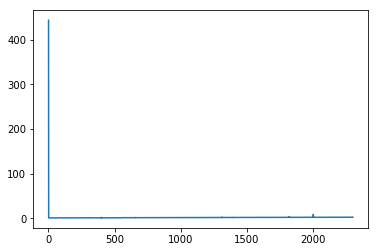

In [85]:
NN.plot_clocks()

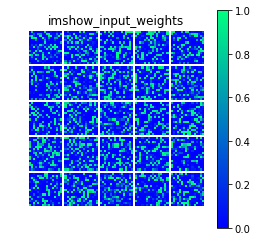

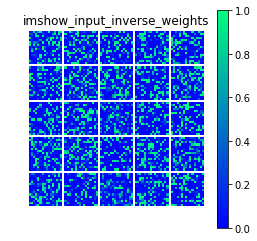

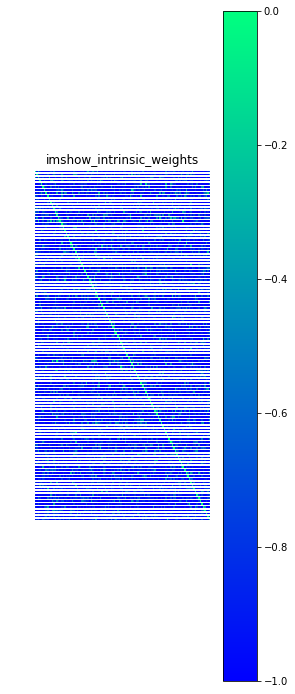

In [93]:
NN.imshow_forward_weights('H', 5, 5, 16, 16)
NN.imshow_intrinsic_weights('H', 113, 1, 1, 113)

In [94]:
print(np.array(NN.StateMonitorH.t/ms)[4])
interval = NN.StateMonitorH.t/ms
print(monitor['H']['variables'])
print([interval[0],interval[-1]+1])
print(NN.StateMonitorH.a[0][int(interval[0]):int(interval[-1]+1)])

4.0
['I_inp', 'I_intr', 'I', 'a']
[0.0, 460000.0]
[ 0.23201302  0.22357713  0.21544796 ...,  0.0009523   0.00091767
  0.00088431]


In [106]:
NN.StateMonitorH.I_inp

array([[ 0.        ,  6.43036902,  8.66522822, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  5.96501092,  9.2892535 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  5.09157038,  7.90955744, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  5.64715974,  7.83811226, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  5.19780304,  8.21420464, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  5.02198495,  8.29507514, ...,  0.        ,
         0.        ,  0.        ]])

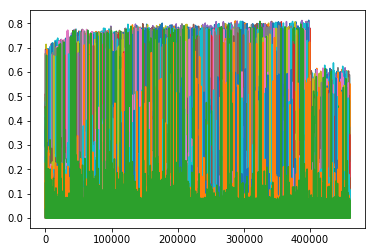

In [112]:
#NN.plot_H(monitor['H']['variables'], np.arange(100000), np.arange(len(NN.H)))
plt.plot(np.array(NN.StateMonitorH.t/ms), NN.StateMonitorH.a.transpose())
plt.show()

In [ ]:
NN.plot_weights('Input_weights', NN.SynapseMonitorInput.t/ms, np.arange(20))

In [ ]:
NN.plot_weights('Intrinsic_output_weights', NN.SynapseMonitorIntrinsicOutput.t/ms, np.arange(20))

In [25]:
NN.save_weights('./LeNet_embedding_saved_network')

сохранение сети в файл ./LeNet_embedding_saved_network
